## Armando las etiquetas con los objetos en cada foto

In [10]:
#export
from src.nb_02 import *

In [2]:
files = pd.Series(os.listdir('../data/raw/train_annotations_pascal/'))

files = files.str.extract('([0-9]+)').values.squeeze(-1)

In [3]:
tags = pd.read_csv('../data/interim/fixed_train.csv', index_col='fileName', usecols=['fileName','tag'])

Para cada categoría cuento la cantidad de apariciones de cada objeto

In [ ]:
import xml.etree.ElementTree as ET

obj_counts = {i:{} for i in range(16)}
tag_counts = {}
for file in files:
    tree = ET.parse('../data/raw/train_annotations_instance/'+file+'.jpg.xml')
    root = tree.getroot()
    objs = []
    for obj in root.findall('object/name'):
        name = obj.text.split('\n')[1]
        name = name.split('crop')[0].strip()
        name = name.split('occluded')[0].strip()
        objs.append(name)
    for obj in set(objs):
        tag = tags.loc[int(file), 'tag']
        tag_counts[tag] = tag_counts.get(tag, 0) + 1
        obj_counts[tag][obj] = obj_counts[tag].get(obj, 0) + 1

Me quedo con los más comunes

In [ ]:
most_common_objects = {}
for i in range(16):
    all_objects = pd.Series(obj_counts[i]).sort_values(ascending=False)
    all_objects = all_objects/all_objects.max()
    
    most_common_objects[i] = all_objects[all_objects > 0.1].index.values

In [ ]:
most_common_objects[1] #Bathroom

Para cada foto me quedo con los objetos que aparecen en la lista de los más comunes para su categoría

In [ ]:
import xml.etree.ElementTree as ET

objs = {i:{} for i in range(16)}
for file in files:
    tree = ET.parse('../data/raw/train_annotations_instance/'+file+'.jpg.xml')
    root = tree.getroot()
    objs = []
    for obj in root.findall('object/name'):
        name = obj.text.split('\n')[1]
        name = name.split('crop')[0].strip()
        name = name.split('occluded')[0].strip()
        objs.append(name)
    tag = tags.loc[int(file), 'tag']
    objs = set(objs).intersection(set(most_common_objects[tag]))
    tags.loc[int(file), 'objects'] = ', '.join(objs)

In [ ]:
tags = tags['objects'].dropna()
tags = tags.reset_index()
tags['fileName'] = 'train/' + tags['fileName'].astype(str) + '.jpg'

Ojo que hay fotos que quedaron sin objetos.

In [ ]:
tags.loc[np.where(tags['objects'].str.len() == 0)[0]]

In [ ]:
tags = tags.loc[np.where(tags['objects'].str.len() > 0)[0]]

In [ ]:
#tags.to_csv('../data/interim/obj_tags.csv', index=False)

## Entrenamiento

In [1]:
#export
from exp.nb_02 import *

In [2]:
tags = pd.read_csv('../data/interim/obj_tags.csv').dropna().reset_index(drop=True)

In [3]:
path = Path('../data/raw/')

In [4]:
bs=16
data = (ImageList
        .from_df(tags, path)
        .split_by_rand_pct(valid_pct=0.2)
        .label_from_df(label_delim=',')
#        .add_test_folder('test')
        .transform(get_transforms(), size=299)
        .databunch(bs=bs)
       )

/home/schouhy/anaconda3/envs/despegar/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


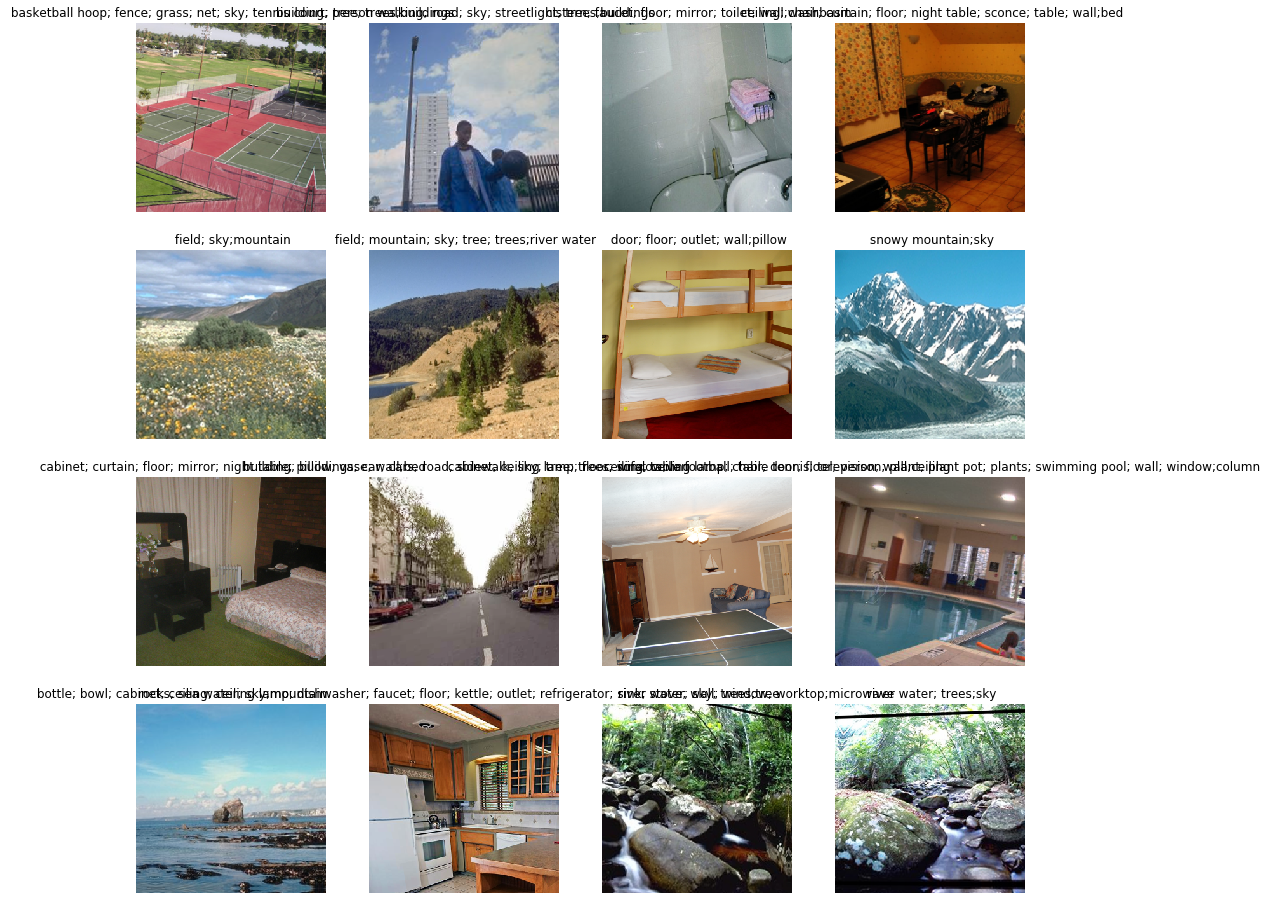

In [5]:
data.show_batch()

In [6]:
from functools import partial

acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [8]:
loss_func = BCEWithLogitsFlat()
bce_learner
learn = cnn_learner(data, models.resnet50, metrics=[BalancedAccuracy(one_hot=one_hot)], bn_wd=False)
#learn = Learner(data, models.xresnet50(c_out=data.c), loss_func=loss_func, metrics=[acc_02, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


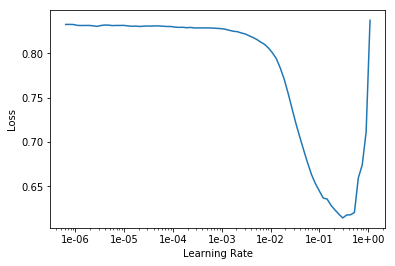

In [9]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(100, 1e-2)

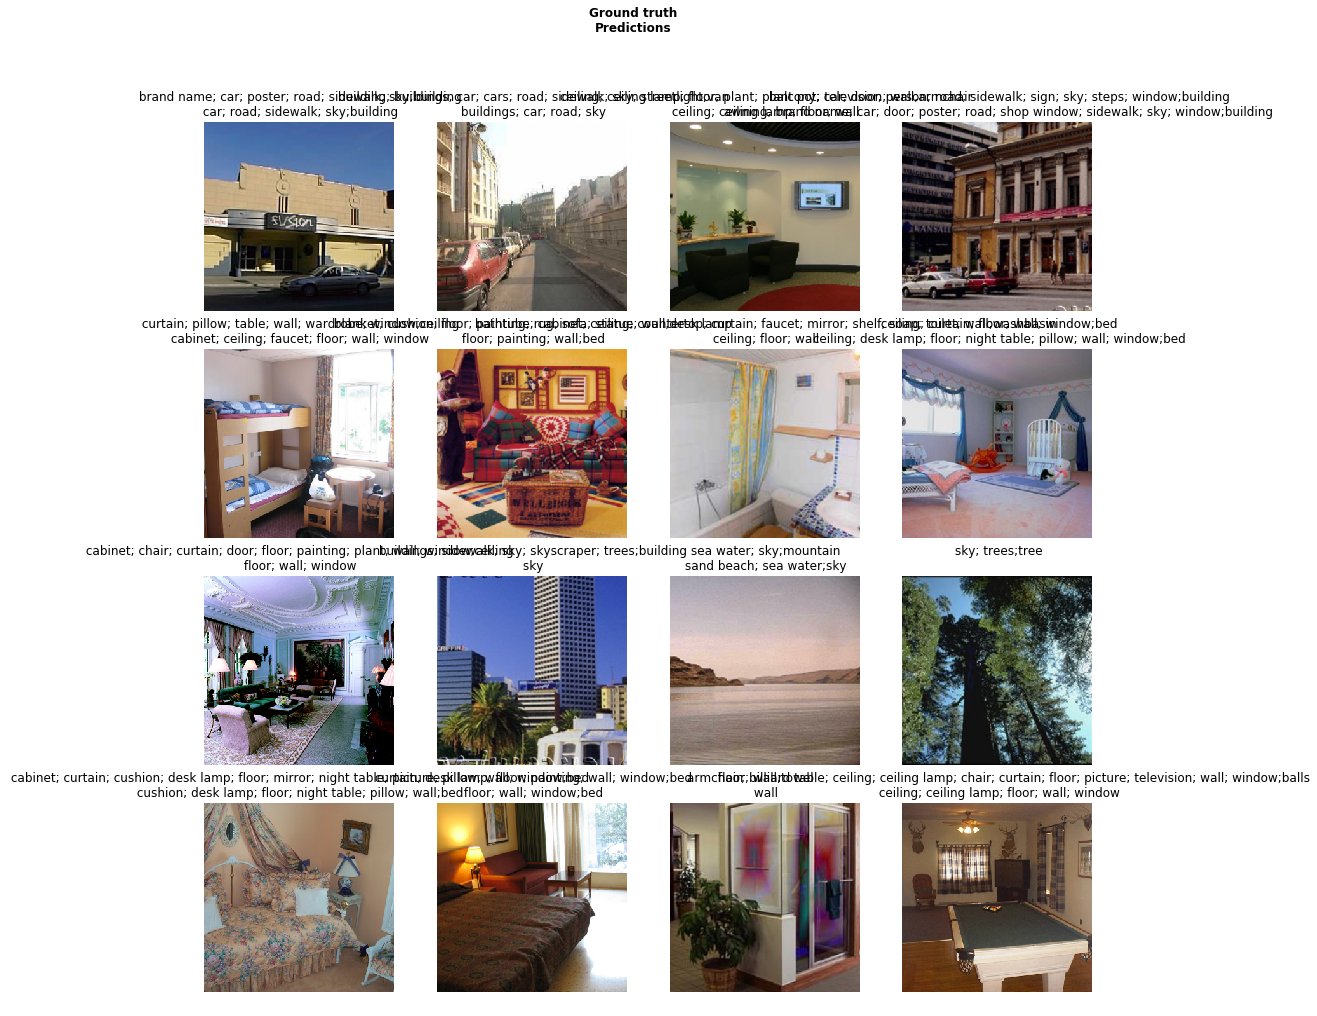

In [9]:
learn.show_results()

In [10]:
#learn.save('resnet-50_tags')

Guardo la parte de la cnn por separado

In [21]:
#torch.save(nn.Sequential(*list(learn.model.children())[:-3]).state_dict(), 
#           '../models/resnset-50_tags')